In [2]:
!pip install opencv-python numpy

In [3]:
!pip install matplotlib

#### Setup and Parameters

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [21]:
# --- CONFIGURATION ---
# Number of INTERNAL corners (width, height)
# For a 9x6 square board, there are 8x5 internal corners.
CHECKERBOARD = (8, 5) 

# Termination criteria for sub-pixel accuracy
# We stop when either the accuracy reaches 0.001 or 30 iterations are met.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(7,4,0)
# These represent the coordinates of the corners in the real world.
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

# Arrays to store vectors from all your images.
objpoints = [] # 3D point in real world space
imgpoints = [] # 2D points in image plane

#### Extracting Corners From Videos

In [13]:
video_files = ['checkerboard/IMG_1059.MOV', 'checkerboard/IMG_1060.MOV', 'checkerboard/IMG_1061.MOV', 'checkerboard/IMG_1062.MOV']

In [ ]:
# found_count = 0
# sample_rate = 10  # Process every 10th frame to save time
# image_size = None

# for video_path in video_files:
#     print(f"Processing: {video_path}")
#     cap = cv2.VideoCapture(video_path)
    
#     frame_in_video = 0
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break

#         if frame_in_video % sample_rate == 0:
#             gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
#             # Store image size (needed for the next step)
#             if image_size is None:
#                 image_size = gray.shape[::-1] # (width, height)

#             # Find the corners
#             ret_corners, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)

#             if ret_corners:
#                 objpoints.append(objp)
#                 corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
#                 imgpoints.append(corners2)
#                 found_count += 1
        
#         frame_in_video += 1
    
#     cap.release()

# print(f"\nFinished! Total valid frames collected across all videos: {found_count}")

Processing: checkerboard/IMG_1059.MOV
Processing: checkerboard/IMG_1060.MOV
Processing: checkerboard/IMG_1061.MOV
Processing: checkerboard/IMG_1062.MOV

Finished! Total valid frames collected across all videos: 11


In [22]:
found_count = 0
sample_rate = 3 # Check every 3rd frame
image_size = None


for video_path in video_files:
    print(f"Processing: {video_path}")
    cap = cv2.VideoCapture(video_path)
    
    frame_in_video = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_in_video % sample_rate == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            if image_size is None:
                image_size = gray.shape[::-1]

            # Adding 'flags' to help detection: 
            # ADAPTIVE_THRESH handles varying light
            # FAST_CHECK speeds up frames where the board isn't visible
            ret_corners, corners = cv2.findChessboardCorners(
                gray, CHECKERBOARD, 
                cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK
            )

            if ret_corners:
                objpoints.append(objp)
                corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
                imgpoints.append(corners2)
                found_count += 1
        
        frame_in_video += 1
    cap.release()

print(f"\nNew total valid frames: {found_count}")

Processing: checkerboard/IMG_1059.MOV
Processing: checkerboard/IMG_1060.MOV
Processing: checkerboard/IMG_1061.MOV
Processing: checkerboard/IMG_1062.MOV

New total valid frames: 30


#### Calibration

In [23]:
# Perform the camera calibration
# ret: the RMS re-projection error (lower is better, ideally < 1.0)
# mtx: Camera Matrix (focal length, optical center)
# dist: Distortion Coefficients
# rvecs / tvecs: Rotation and Translation vectors (extrinsic parameters)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)

print("--- Calibration Results ---")
print(f"\nRe-projection Error: {ret:.4f}")
print("\nCamera Matrix (K):")
print(mtx)
print("\nDistortion Coefficients (d):")
print(dist)

# Save these results so you don't have to re-run the video processing again
np.savez("camera_calib.npz", mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)
print("\nCalibration data saved to 'camera_calib.npz'")

--- Calibration Results ---

Re-projection Error: 1.9759

Camera Matrix (K):
[[3.08055609e+03 0.00000000e+00 1.30380581e+03]
 [0.00000000e+00 3.03846166e+03 1.85817047e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients (d):
[[ 3.72224562e-01 -2.64736987e+00 -1.13287975e-03  6.12750847e-02
   1.39047007e+01]]

Calibration data saved to 'camera_calib.npz'


#### Testing the calibration

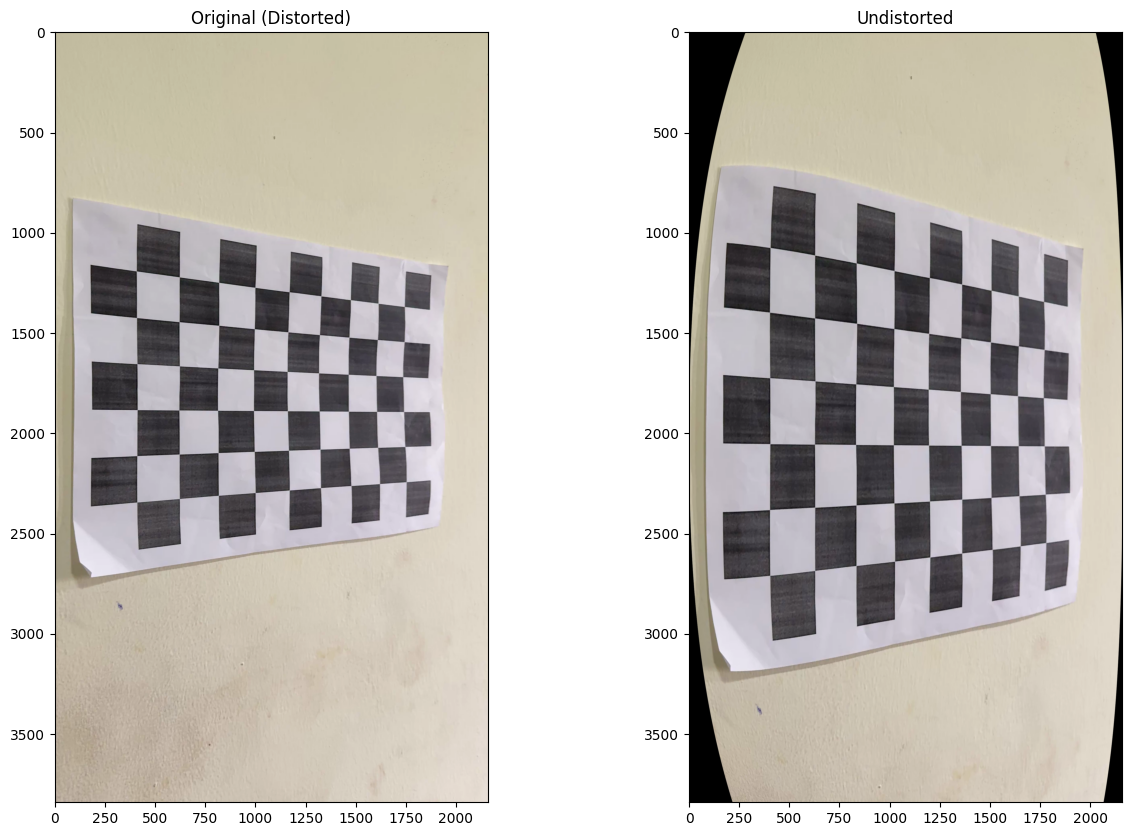

In [24]:
# 1. Grab a sample frame from your video
cap = cv2.VideoCapture(video_files[0])
ret, frame = cap.read()
cap.release()

if ret:
    h, w = frame.shape[:2]

    # 2. Refine the camera matrix 
    # alpha=0: zooms in to remove all black pixels (crops)
    # alpha=1: keeps all pixels but leaves black edges where data is missing
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

    # 3. Undistort
    dst = cv2.undistort(frame, mtx, dist, None, newcameramtx)

    # 4. Crop the image based on the ROI (Region of Interest)
    x, y, w_roi, h_roi = roi
    dst_cropped = dst[y:y+h_roi, x:x+w_roi]

    # 5. Display the comparison
    plt.figure(figsize=(15, 10))
    plt.subplot(121), plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), plt.title('Original (Distorted)')
    plt.subplot(122), plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)), plt.title('Undistorted')
    plt.show()
else:
    print("Could not read frame.")